In [2]:
import numpy as np
import pandas as pd

In [3]:
norm_df = pd.read_csv("final_dataset.csv")
norm_df.head()

,Content,Label
0,notability magnus howie tag placed magnus howi...,0
1,big plan,0
2,najbolje je idea jean idea drug ako see bird m...,1
3,disruptive appear attention seeking remark arg...,1
4,reign man really ignorant person perfect examp...,1


In [4]:
norm_df.dropna(how='any', inplace=True)

##### Performing experiments to get the best feature engineering technique between BoW and TF-IDF

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

uri = os.getenv("MLFLOW_URI")
repo_owner = os.getenv("OWNER")
repo_name = os.getenv("REPO")

In [5]:
import mlflow
import dagshub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
VECTORIZERS = {
    "BoW" : CountVectorizer(max_features=2500, min_df=5),
    "TF-IDF" : TfidfVectorizer(max_features=2500, min_df=5)
}

MODELS = {
    "DecisionTree" : DecisionTreeClassifier(max_depth=30),
    "RandomForest" : RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1),
    "GradientBoosting" : GradientBoostingClassifier(n_estimators=500, max_depth=7, learning_rate=0.1, subsample=0.5),
    "XgBoost" : XGBClassifier(n_estimators=500, max_depth=7, learning_rate=0.1, subsample=0.5, n_jobs=-1)
}

In [ ]:
import mlflow
import dagshub

if uri is None:
	raise ValueError("MLFLOW_URI environment variable is not set.")
mlflow.set_tracking_uri(uri)

if repo_owner or repo_name is None:
	raise ValueError("Missing dagshub logging environment credentials.")
dagshub.init(repo_owner=repo_owner, repo_name=repo_name, mlflow=True)

mlflow.set_experiment("BoW vs TF-IDF")

In [8]:
# Function to log hyperparameters of the trained model to Mlflow
def log_model_params(model_name, model):
    params_to_log = {}

    if model_name == "DecisionTree":
        params_to_log["max_depth"] = model.max_depth
        params_to_log["criterion"] = model.criterion

    elif model_name == "RandomForest":
        params_to_log["n_estimator"] = model.n_estimators
        params_to_log["max_depth"] = model.max_depth

    elif model_name == "GradientBoosting":
        params_to_log["n_estimators"] = model.n_estimators
        params_to_log["learning_rate"] = model.learning_rate
        params_to_log["max_depth"] = model.max_depth

    elif model_name == "XgBoost":
        params_to_log["n_estimators"] = model.n_estimators
        params_to_log["learning_rate"] = model.learning_rate
        params_to_log["max_depth"] = model.max_depth
        params_to_log["tree_method"] = model.tree_method

    mlflow.log_params(params_to_log)

In [ ]:
def run_experiments(df):
    for model_name, model_algo in MODELS.items():
        for vec_name, vectorizer in VECTORIZERS.items():
            with mlflow.start_run(run_name=f"{model_name} with {vec_name}"):
                try:
                    print(f"Training {model_name} with {vec_name}")
                    X = vectorizer.fit_transform(df['Content'])
                    y = df['Label'].values.ravel()
    
                    mlflow.log_params({
                        "vectorizer" : vec_name,
                        "model" : model_name}
                    )

                    # Split data into training and testing
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
                    model = model_algo
                    model.fit(X_train, y_train)

                    print("Logging model hyperparameters to Mlflow")
                    log_model_params(model_name, model)

                    print("Evaluating model")
                    y_pred = model.predict(X_test)
    
                    metrics = {
                        "accuracy" : accuracy_score(y_test, y_pred),
                        "precision" : precision_score(y_test, y_pred),
                        "recall" : recall_score(y_test, y_pred),
                        "F1" : f1_score(y_test, y_pred),
                        "roc_auc" : roc_auc_score(y_test, y_pred)
                    }

                    print("Logging model metrics")
                    mlflow.log_metrics(metrics)
                    
                    print("Done! \n\n")
    
                except Exception as e:
                    print(f"Error in model training and or tracking: {e}")
                    raise e

In [23]:
run_experiments(norm_df)

Training DecisionTree with BoW
Logging model hyperparameters to Mlflow
Evaluating model
Logging model metrics
Done! 


🏃 View run DecisionTree with BoW at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/1/runs/5d6d2524478c4f3dbe9660a2aab49275
🧪 View experiment at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/1
Training DecisionTree with Bi-Gram
Logging model hyperparameters to Mlflow
Evaluating model
Logging model metrics
Done! 


🏃 View run DecisionTree with Bi-Gram at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/1/runs/19d0f208daf047b6b06cca83f7754cf6
🧪 View experiment at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/1
Training DecisionTree with TF-IDF
Logging model hyperparameters to Mlflow
Evaluating model
Logging model metrics
Done! 


🏃 View run DecisionTree with TF-IDF at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/1/runs/b61fcdfacaa04860be259ab01faf

In [ ]:
%cd ..

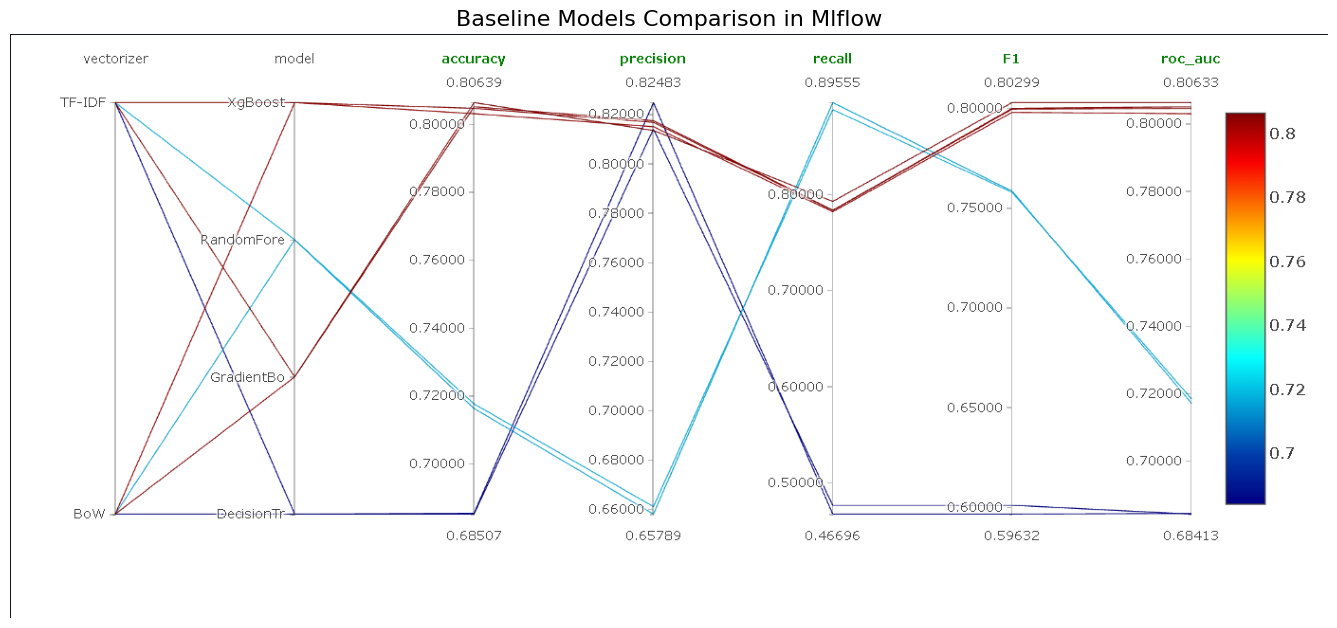

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("images/BoW_vs_TF-IDF.png")
plt.figure(figsize=(17, 13))
plt.imshow(img)
plt.title("Baseline Models Comparison in Mlflow", fontsize=16, color='black')
plt.axis('off')
plt.show()